In [8]:
from advanced_ba_project.data import ForestDataset, get_dataloaders
import hydra
import os
from pathlib import Path
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

from omegaconf import DictConfig
from PIL import Image

In order to compare our deforestation model's perfomance, we create a baseline model that looks at each pixels and classify it as a tree if that pixel is more green than the red and blue value. 

In [9]:
def green_tree_detector(image_batch, threshold=0.1):
    """
    Simple baseline that detects trees based on green channel values.
    
    Args:
        image_batch: Tensor of shape [batch_size, 3, 256, 256]
        threshold: How much greener a pixel must be compared to other channels
    
    Returns:
        Tensor of shape [batch_size, 1, 256, 256] with binary tree mask
    """
    batch_size = image_batch.shape[0]
    device = image_batch.device
    
    # Extract RGB channels
    r = image_batch[:, 0]  # Red channel
    g = image_batch[:, 1]  # Green channel
    b = image_batch[:, 2]  # Blue channel
    
    # Consider a pixel a tree if green value is dominant
    # g > r + threshold AND g > b + threshold
    tree_mask = ((g > (r + threshold)) & (g > (b + threshold))).float()
    
    # Reshape to [batch_size, 1, 256, 256] to match ground truth format
    return tree_mask.unsqueeze(1)

We define the baseline model as a function that takes in a pixel and returns 1 if the pixel is more green than red and blue, otherwise it returns 0. Also, we include a threshold parameter that allows us to adjust the sensitivity of the model. The threshold is a value between 0 and 1, where 0 means that the pixel must be completely green to be classified as a tree, and 1 means that the pixel can be any color to be classified as a tree. We also have an evaluation function so we can compare the baseline to the deforestation model.

In [10]:
def evaluate_detector(dataloader, threshold=0.1):
    """Evaluate the green tree detector on the given dataloader."""
    device = next(iter(dataloader))[0].device
    
    # Initialize metrics
    total_pixels = 0
    metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'iou': 0
    }
    
    # Process each batch
    for images, masks in tqdm(dataloader, desc="Evaluating baseline detector"):
        # Generate predictions
        predictions = green_tree_detector(images, threshold=threshold)
        
        # Convert to binary predictions (0 or 1)
        pred_binary = (predictions > 0.5).float()
        
        # Flatten tensors for metric calculation
        pred_flat = pred_binary.cpu().numpy().flatten().astype(int)
        mask_flat = masks.cpu().numpy().flatten().astype(int)
        
        # Update metrics
        batch_pixels = pred_flat.shape[0]
        total_pixels += batch_pixels
        
        metrics['accuracy'] += accuracy_score(mask_flat, pred_flat) * batch_pixels
        metrics['precision'] += precision_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['recall'] += recall_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['f1'] += f1_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
        metrics['iou'] += jaccard_score(mask_flat, pred_flat, zero_division=0) * batch_pixels
    
    # Calculate final metrics
    for key in metrics:
        metrics[key] /= total_pixels
    
    return metrics


def visualize_prediction(image, threshold=0.01, ground_truth=None):
    """
    Takes a single image and visualizes the original image alongside the predicted mask.
    
    Args:
        image: Tensor of shape [3, 256, 256] - single RGB image
        threshold: Threshold for green detection
        ground_truth: Optional ground truth mask of shape [1, 256, 256]
    
    Returns:
        Displays the visualization and returns the predicted mask
    """
    import matplotlib.pyplot as plt
    
    

    image = Image.open(image).convert("RGB")
    image = np.array(image)
    image = image.transpose(2, 0, 1)
    
    # Ensure image is a tensor with batch dimension and on CPU
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension
        
    # Generate prediction
    with torch.no_grad():
        prediction = green_tree_detector(image, threshold=threshold)
    
    # Convert to numpy for visualization
    image_np = image[0].permute(1,2,0).cpu().numpy()  # [H, W, 3]
    mask_np = prediction[0, 0].cpu().numpy()            # [H, W]
    
    # Create figure
    n_plots = 3 if ground_truth is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
    
    # Plot original image
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Plot predicted mask
    axes[1].imshow(mask_np, cmap='viridis')
    axes[1].set_title(f"Predicted Mask (threshold={threshold:.2f})")
    axes[1].axis("off")
    
    # Plot ground truth if provided
    if ground_truth is not None:
        if isinstance(ground_truth, torch.Tensor):
            if len(ground_truth.shape) == 4:
                gt_np = ground_truth[0, 0].cpu().numpy()
            else:
                gt_np = ground_truth[0].cpu().numpy()
        else:
            gt_np = ground_truth
            
        axes[2].imshow(gt_np, cmap='viridis')
        axes[2].set_title("Ground Truth")
        axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return prediction

In [11]:
@hydra.main(config_path=f"{os.getcwd()}/configs", config_name="config", version_base="1.2")
def main(cfg: DictConfig):
    # Load data
    train_loader, val_loader = get_dataloaders(
        data_path=Path(cfg.dataset.data_path),
        metadata_file=cfg.dataset.metadata_file,
        batch_size=cfg.hyperparameters.batch_size,
        subset=cfg.dataset.subset,
    )
    
    # Try different thresholds
    thresholds = [0, 0.01, 0.025, 0.05]
    best_threshold = None
    best_f1 = -1
    
    print("Evaluating green tree detector baseline with different thresholds...")
    for threshold in thresholds:
        print(f"\nTesting threshold: {threshold}")
        metrics = evaluate_detector(val_loader, threshold=threshold)
        
        print(f"Results:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1 Score:  {metrics['f1']:.4f}")
        print(f"  IoU:       {metrics['iou']:.4f}")
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
    
    print(f"\nBest threshold: {best_threshold} with F1 score: {best_f1:.4f}")
    
    return None

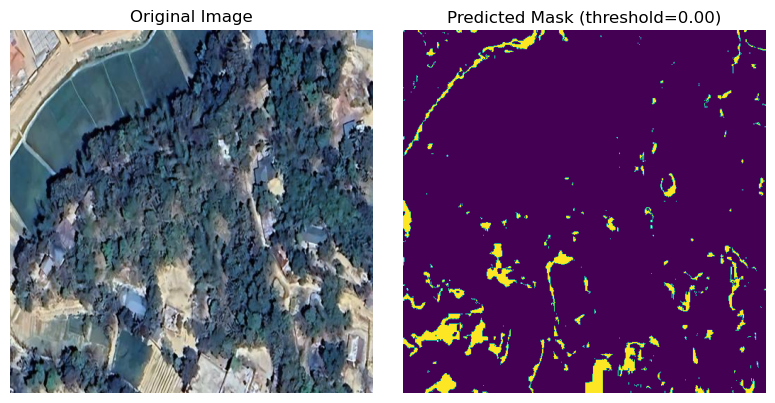

tensor([[[[1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [ ]:
visualize_prediction(
    image="../data/raw/roboflow/train/images/rohingyacamp102_png_jpg.rf.4829a3dee62e7b3c171dbca75f66fefe.jpg",  # Replace with your image path
    threshold=0,  # Adjust threshold as needed
    ground_truth=None  # Optionally provide ground truth mask
)

In [ ]:
main()

usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/kristofferkjaer/Library/Jupyter/runtime/kernel-v3637b672d27fda371348e32c3d8388d1685fc612f.json


SystemExit: 2

For evaluating the performance of the baseline model, we will use the same metrics as the deforestation model. We will calculate the accuracy, precision, recall, and F1 score of the baseline model.

For our baseline, we get the following results:


Results:
  Accuracy:  0.8122
  Precision: 0.7053
  Recall:    0.5747
  F1 Score:  0.6251
  IoU:       0.4607

For the baseline model we see a accuracy of 81.22%, a precision of 70.53%, a recall of 57.47%, and an F1 score of 62.51%. The IoU is 46.07%. This means that the baseline model is not very good at detecting deforestation.